## An Initial CHURN Analysis for TELCO CUSTOMER BASE (TCB): 

#### WORKING PREMISE:

**While each Customer will have their own particular reason for parting ways with Telco, the two key ingredients needed for Customer churn are:**
1. Low or No "Perception of Commitment" to Telco.
2. Minimal Switching Costs associated with leaving Telco.

## The goals of this initial exploration are as follows:
- Discover the "Driving Factors" which contribute most to Customer churn.
- Discover the Customer segment which is most likely to churn.
- Discover the Customer segment which is most responsible for revenue.
- Identify those Customers who exhibit the characteristics of both Customer segments.
- Create a Machine Learning Model which can predict Customer churn with greater accuracy than baseline.


In [1]:
# DS Libraries
import pandas as pd
import numpy as np
from scipy import stats

# Data Acquisition
from pydataset import data
import env
import acquire as acq
import prepare as prp

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# scikit learn submodules
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [2]:
# Let's Acquire and Prepare the DataFrame
# load telco via acquire.py (be sure to place acquire.py in same directory as this Notebook)
df = acq.new_telco_data()

In [3]:
# Using the prep_telco function in prepare.py, we will drop unneeded columns and encode those that require
df = prp.prep_telco(df)

## Initial questions and hypothesis:
#### What % of Telco Customer Base (TCB) has No "Perception of  Commitment" to Telco in combination with low "Switching Costs"?

- Do customers with **"Month-to-Month"** contracts churn out at a statistically significant greater rate than the overall population?
- Do customers with **"Paperless Billing"** churn out at a statistically significant greater rate than the overall population?
- Do customers **without "Dependents"** churn out at a statistically significant greater rate than the overall population?
- Do customers who exist within these customer segments churn out at a statistically significant greater rate than the overall population?

## HYPOTHESIS: Customers in these segmnents churn at greater rates than the overall Telco Customer Base (TCB)

In [4]:
# Using prepare.py, split the Dataset into TRAIN(.56), VALIDATE(.24), and TEST(.20) subsets:
train, validate, test = prp.split_data(df,'churn')
# quick check of the numbers for each should be 3943-1691-1409
train.shape[0],validate.shape[0],test.shape[0]

(3943, 1691, 1409)

#### Technical disclaimer...

- The original dataset contained 7043 records.  Due to the unique req's for building a ML model that actually functions properly with UNSEEN data, we have split the data into several subsets, for Training the model and for Testing the model.  
- Therefore, note that our univariate analyses will imply 3943 total records instead.  The conclusions gained from the analysis will be just as valid as if we had used the full dataset.

## BLUF
### Let us now compare Customer Counts in a few specific Categories:

- **70%** of TCB has **NO DEPENDENTS** on Telco Data/Voice Plans  
- **59%** of TCB has **PAPERLESS BILLING** on Telco Data/Voice Plans 
- **54%** of TCB has **MONTH-to-MONTH** contracts on Telco Data/Voice Plans  

### Taken in combination, this represents 22.3 % of TCB

### What are the total counts of TCB by DEPENDENTS status?

TCB with NO DEPENDENTS:


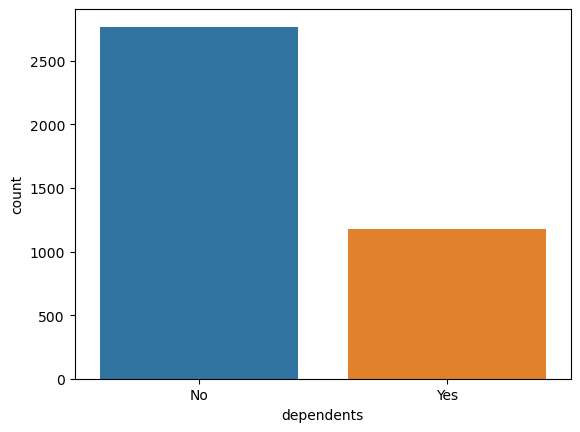

     dependents  dependents
No         2768    0.702004
Yes        1175    0.297996


In [5]:
# Barchart showing raw counts of customers with dependents and customers without:
print(f'TCB with NO DEPENDENTS:')
sns.countplot(data=train, x='dependents')
plt.show()
print(
    pd.concat([train['dependents'].value_counts(),
    train['dependents'].value_counts(normalize=True)],
         axis=1))

### TAKEAWAY:  70% of TCB does not have to consider the Switching Costs associated with transitioning DEPENDENTS to a new service provider.

### What are the total counts of TCB by PAPERLESS BILLING status?

TCB with PAPERLESS BILLING:


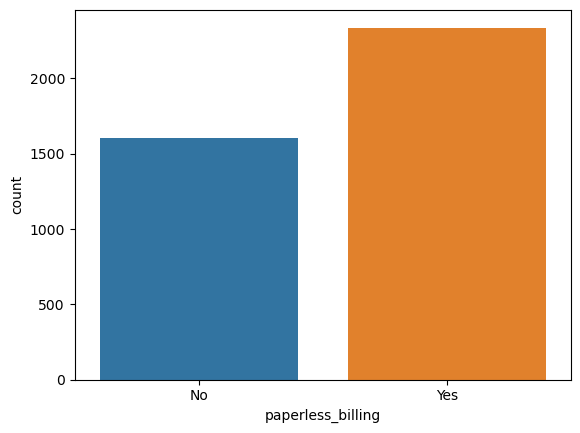

     paperless_billing  paperless_billing
Yes               2338            0.59295
No                1605            0.40705


In [6]:
# Barchart showing raw counts of customers with paperless_billing and customers without:
print(f'TCB with PAPERLESS BILLING:')
sns.countplot(data=train, x='paperless_billing')
plt.show()
print(
    pd.concat([train['paperless_billing'].value_counts(),
    train['paperless_billing'].value_counts(normalize=True)],
         axis=1))

### TAKEAWAY:  59% of TCB never sees a monthly paper bill.  This may reduce some Customers "Perception of Commitment"...  Out of Sight, Out of Mind...

### What are the total counts of TCB by CONTRACT TYPE?

TCB with MONTH-to_MONTH contract:


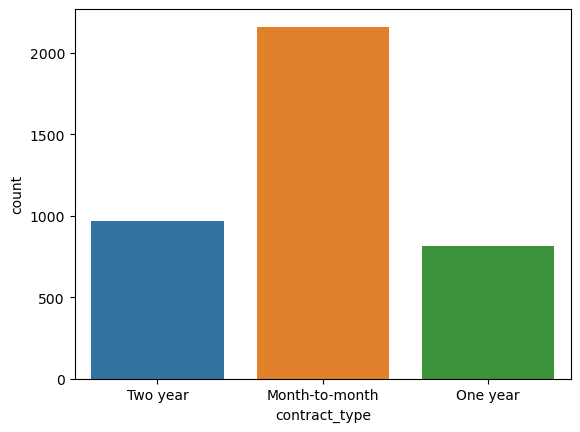

                contract_type  contract_type
Month-to-month           2161       0.548060
Two year                  969       0.245752
One year                  813       0.206188


In [7]:
# Barchart showing raw counts of customers by contract type:
print(f'TCB with MONTH-to_MONTH contract:')
sns.countplot(data=train, x='contract_type')
plt.show()
print(
    pd.concat([train['contract_type'].value_counts(),
    train['contract_type'].value_counts(normalize=True)],
         axis=1))

### TAKEAWAY:  54% of TCB does not have to consider monetary Switching Costs associated with breaking an extended contract.  Instead, they can churn-out at their convenience.

# BOTTOM LINE  \#1: 1 in 5 Customers exhibit ALL of these characteristics and a majority of Customers fall into at least one of these categories.

--------
--------
--------

### Let us now compare Customer Churn Rates in these Categories and compare them to the overall TCB mean average:

--------

### Do Customers WITHOUT DEPENDENTS Churn at a greater rate than the Overall TCB Churn Rate?

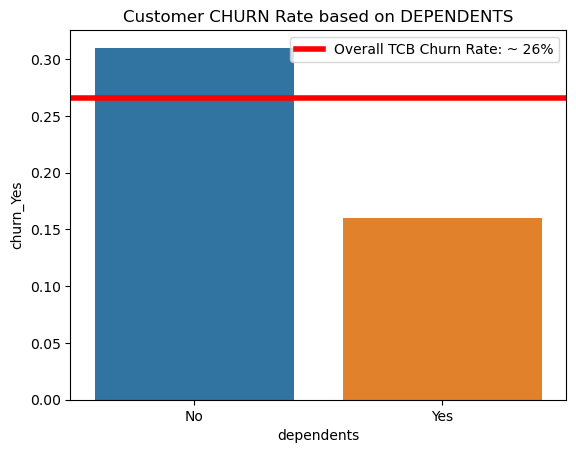

In [8]:
# Chart showing churn rate of customers by dependent status, as compared to overall churn rate:
sns.barplot(data=train,
            x='dependents',
            y = 'churn_Yes',
           ci=False)
plt.title(f'Customer CHURN Rate based on DEPENDENTS')
plt.axhline(train.churn_Yes.mean(),label='Overall TCB Churn Rate: ~ 26%',color='red',linewidth=4)
plt.legend()
plt.show()

### TAKEAWAY:  With the Overall TCB Churn Rate at ~ 26%, Customers WITHOUT DEPENDENTS churn-out at a sample rate of ~ 31% .

### This chart is nice, however how can we be sure that these results are not just due to random sampling?  How statistically significant is this result?
#### Glad you asked, let's run a quick Chi$^2$ test for Independence to find out how likely it is that we would have obtained these results via random sampling...

In [9]:
# Lets Run a Chi2 Test to find out how likely it is that we would get this result by random sampling:

# H0: No statistically significant difference exists between the churn rates of customers with DEPENDENTS 
#     and ALL customers. ie the two samples were drawn from the same population.
    
# H1: A statistically significant difference exists between the churn rates of customers with DEPENDENTS 
#     and ALL customers.  ie the two samples were drawn from differing populations.

df_dependents_x =pd.crosstab(train['dependents'],train['churn'])
df_dependents_x
stats.chi2_contingency(df_dependents_x)

# This function has 4 outputs: Chi2 Coefficient (94.41...), p-value (2.55 e-22)(think...very close to ZERO)),
# the number of Degrees of Freedom (1) and a 2-dim array showing the expected frequency of each case assuming that
# null hypothesis were True
# With a p-value < 0.05, we can REJECT the NULL hypothesis.  There is evidence to suggest that a statistically
# significant difference exists between the two rates.

(94.41648584351759,
 2.556541466336363e-22,
 1,
 array([[2033.70428608,  734.29571392],
        [ 863.29571392,  311.70428608]]))

### TAKEAWAY:  With a p-value < 0.05, we can REJECT the NULL hypothesis.  There is evidence to suggest that a statistically significant difference exists between the two rates.

--------

### Do Customers WITH PAPERLESS BILLING Churn at a greater rate than the Overall TCB Churn Rate?

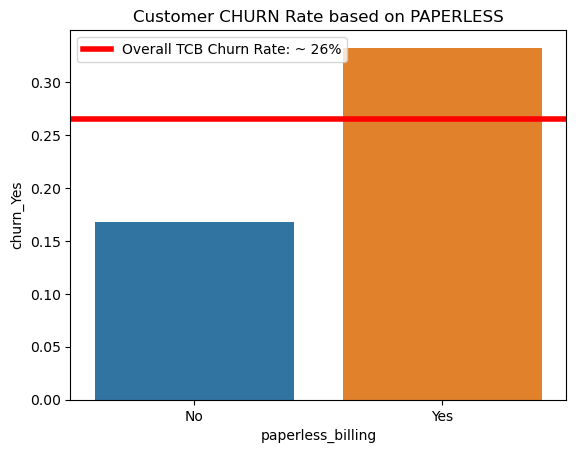

In [10]:
# Chart showing churn rate of customers by paperless status, as compared to overall churn rate:
sns.barplot(data=train,
            x='paperless_billing',
            y = 'churn_Yes',
           ci=False)
plt.title(f'Customer CHURN Rate based on PAPERLESS')
plt.axhline(train.churn_Yes.mean(),label='Overall TCB Churn Rate: ~ 26%',color='red',linewidth=4)
plt.legend()
plt.show()

### TAKEAWAY:  With the Overall TCB Churn Rate at ~ 26%, Customers WITH PAPERLESS BILLING churn-out at a sample rate of ~ 33% .

### Again, how statistically significant is this result?
#### Let's run a quick Chi$^2$ test for Independence to find out how likely it is that we would have obtained these results via random sampling...

In [11]:
# Lets Run a Chi2 Test to find out how likely it is that we would get this result by random sampling:

# H0: No statistically significant difference exists between the churn rates of customers with DEPENDENTS 
#     and ALL customers. ie the two samples were drawn from the same population.
    
# H1: A statistically significant difference exists between the churn rates of customers with DEPENDENTS 
#     and ALL customers.  ie the two samples were drawn from differing populations.

df_dependents_x =pd.crosstab(train['paperless_billing'],train['churn'])
df_dependents_x
stats.chi2_contingency(df_dependents_x)

# This function has 4 outputs: Chi2 Coefficient (131.66...), p-value (1.77 e-30)(think...very close to ZERO)),
# the number of Degrees of Freedom (1) and a 2-dim array showing the expected frequency of each case assuming that
# null hypothesis were True
# With a p-value < 0.05, we can REJECT the NULL hypothesis.  There is evidence to suggest that a statistically
# significant difference exists between the two rates.

(131.66139738100526,
 1.7744488509875074e-30,
 1,
 array([[1179.22520923,  425.77479077],
        [1717.77479077,  620.22520923]]))

### TAKEAWAY:  With a p-value < 0.05, we can REJECT the NULL hypothesis.  There is evidence to suggest that a statistically significant difference exists between the two rates.

--------

### Do Customers WITH MONTH-TO-MONTH Contracts Churn at a greater rate than the Overall TCB Churn Rate?

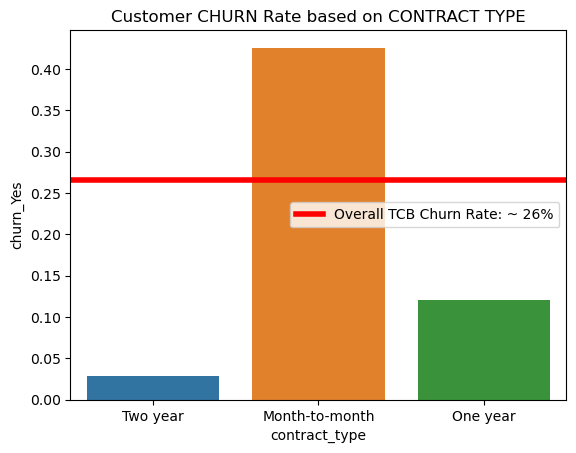

In [13]:
# Chart showing churn rate of customers by contract_type, as compared to overall churn rate:
sns.barplot(data=train,
            x='contract_type',
            y = 'churn_Yes',
           ci=False)
plt.title(f'Customer CHURN Rate based on CONTRACT TYPE')
plt.axhline(train.churn_Yes.mean(),label='Overall TCB Churn Rate: ~ 26%',color='red',linewidth=4)
plt.legend()
plt.show()

### TAKEAWAY:  With the Overall TCB Churn Rate at ~ 26%, Customers with MONTH-TO-MONTH contracts churn-out at a sample rate of ~ 43% .

### How statistically significant is this result?
#### A Chi$^2$ test for Independence to find out how likely it is that we would have obtained these results via random sampling...

In [14]:
# Lets Run a Chi2 Test to find out how likely it is that we would get this result by random sampling:

# H0: No statistically significant difference exists between the churn rates of customers with DEPENDENTS 
#     and ALL customers. ie the two samples were drawn from the same population.
    
# H1: A statistically significant difference exists between the churn rates of customers with DEPENDENTS 
#     and ALL customers.  ie the two samples were drawn from differing populations.

df_dependents_x =pd.crosstab(train['contract_type'],train['churn'])
df_dependents_x
stats.chi2_contingency(df_dependents_x)

# This function has 4 outputs: Chi2 Coefficient (650.61...), p-value (2.25 e-142)(think...very close to ZERO)),
# the number of Degrees of Freedom (2) and a 2-dim array showing the expected frequency of each case assuming that
# null hypothesis were True
# With a p-value < 0.05, we can REJECT the NULL hypothesis.  There is evidence to suggest that a statistically
# significant difference exists between the two rates.

(650.6166776362105,
 5.252711329723749e-142,
 2,
 array([[1587.72939386,  573.27060614],
        [ 597.32716206,  215.67283794],
        [ 711.94344408,  257.05655592]]))

### TAKEAWAY:  With a p-value < 0.05, we can REJECT the NULL hypothesis.  There is evidence to suggest that a statistically significant difference exists between the two rates.

# BOTTOM LINE  \#2: ALL Customers who exist in these segments exhibit a CHURN Rate Greater than the Overall mean TCB rate.

# 1 + 2 = ...
# This situation must be addressed...the largest segment of our TCB also Churns out at the greatest rate.

----
----
----

In [15]:
# We divide the columns into categorical, categorical_encoded, and numerical

cat_cols, cat_cols_e, num_cols = [], [], []
for col in train.columns:
    if train[col].dtype == 'O':
        cat_cols.append(col)
    else:
        if train[col].nunique() < 10:
            cat_cols_e.append(col)
        else:
            num_cols.append(col)
            
# We then assign the needed columns to variables and then affix those column groupings to the appropriate
# TRAIN, VALIDATE, and TEST subsets
X_cols = cat_cols_e
y_cols = 'churn_Yes'
X_cols.remove('churn_Yes')
X_cols,y_cols

X_train = train[X_cols]
y_train = train['churn']

X_validate = validate[X_cols]
y_validate = validate['churn']

X_test = test[X_cols]
y_test = test['churn']

# create the Decision Tree Classifier model 
clf = DecisionTreeClassifier()
# fit the model to the TRAIN dataset:
clf.fit(X_train, y_train)
# use the model by calling for the predictions made via the TRAIN dataset
model_a_preds = clf.predict(X_train)
pd.crosstab(model_a_preds,y_train) # a confusion matrix with ACTUALS as columns and PREDICTIONS as rows

churn,No,Yes
row_0,,
No,2609,475
Yes,288,571


### GIVEN THE FOLLOWING:

- Removing Month-to-Month contracts or any other variable which may appear to be correlated with high churn rates is not feasible.
- Accepting significantly higher Churn rates in certain Customer Segments as just "the cost of doing business" is not a proactive approach.
- Providing "loyalty incentives" to all customers regardless of their propensity to Churn is not economically viable for long-term growth.

# BOTTOM LINE  \#3: We must find a way to IDENTIFY those Customers who are most likely to Churn and provide Targeted "Loyalty Incentives" designed for Customer retention. 

## The good news is that we have a prototype Model that is being tested exactly for this purpose!

# 1 + 2 = 3

----
----
----

## LET'S FIRST ESTABLISH OUR BASELINE ACCURACY (73%):
- Current Overall TCB Churn rate is ~26.5%.
- Therefore, 73.5% of TCB has no current propensity to churn. CALL THIS BASELINE ACCURACY (73.5%)
- If we assume all Customers Will Not Churn...we will be wrong in 26.5% of all cases.
- This is the current state of affairs at Telco, and we can easily outperform this baseline. 

### NEXT, WE COMPARE THAT TO A FEW CANDIDATE MODELS:

### MODEL A (codename: Vanilla_Tree) :

- Model TRAIN ACCURACY: 81%
- Model VALIDATE ACCURACY: 77% slighly OVERFIT
- RECALL for YES: 55%

In [16]:
# here is a classification report with many different measurements and ratios based upon the confusion matrix
# for our purposes here we will look at ACCURACY (0.81) and RECALL for the YES class (0.55).

print(
    classification_report(y_train,
                      model_a_preds))

              precision    recall  f1-score   support

          No       0.85      0.90      0.87      2897
         Yes       0.66      0.55      0.60      1046

    accuracy                           0.81      3943
   macro avg       0.76      0.72      0.74      3943
weighted avg       0.80      0.81      0.80      3943



In [17]:
# Here we will evaluate the difference between the ACCURACY score on TRAIN datatset and compare it to the ACCURACY
# score on VALIDATE.  If the difference between the two accuracy scores is aproaching 10, then this is an
# indication that our model may be OVERFIT...w/o explaining the concept, this is not what we want.  We want a model
# that will perform consistently on both TRAIN and VALIDATE.

print(f'''
Performance in accuracy of Decision Tree 1 on training data:
Accuracy (train): {clf.score(X_train, y_train)}
Accuracy (validate): {round(clf.score(X_validate, y_validate), 5)}''')


Performance in accuracy of Decision Tree 1 on training data:
Accuracy (train): 0.806492518387015
Accuracy (validate): 0.76759


### MODEL B (codename: Barry_Bonds) :

- Model ACCURACY: 81% 
- Model VALIDATE ACCURACY: 77% slighly OVERFIT
- RECALL for YES: 59%

In [18]:
# create the Random Forest model 
rf1 = RandomForestClassifier(n_estimators=25)
# fit the model to the TRAIN dataset:
rf1.fit(X_train, y_train)
# use the model by calling for the predictions made via the TRAIN dataset
model_b_preds = rf1.predict(X_train)
pd.crosstab(model_b_preds,y_train) # a confusion matrix with ACTUALS as columns and PREDICTIONS as rows

churn,No,Yes
row_0,,
No,2535,403
Yes,362,643


In [19]:
# here is a classification report with many different measurements and ratios based upon the confusion matrix
# for our purposes here we will look at ACCURACY (0.81) and RECALL for the YES class (0.59).

print(
    classification_report(y_train,
                      model_b_preds))

              precision    recall  f1-score   support

          No       0.86      0.88      0.87      2897
         Yes       0.64      0.61      0.63      1046

    accuracy                           0.81      3943
   macro avg       0.75      0.74      0.75      3943
weighted avg       0.80      0.81      0.80      3943



In [20]:
# Here we will evaluate the difference between the ACCURACY score on TRAIN datatset and compare it to the ACCURACY
# score on VALIDATE.  If the difference between the two accuracy scores is aproaching 10, then this is an
# indication that our model may be OVERFIT...w/o explaining the concept, this is not what we want.  We want a model
# that will perform consistently on both TRAIN and VALIDATE.

print(f'''
Performance in accuracy of Decision Tree 1 on training data:
Accuracy (train): {rf1.score(X_train, y_train)}
Accuracy (validate): {round(rf1.score(X_validate, y_validate), 5)}''')


Performance in accuracy of Decision Tree 1 on training data:
Accuracy (train): 0.8059852903880295
Accuracy (validate): 0.77232


### MODEL C (codename: El_Camino) :


- Model ACCURACY: 81% 
- Model VALIDATE ACCURACY: 77% slighly OVERFIT
- RECALL for YES: 58%

In [21]:
# create the Random Forest model 
rf2 = RandomForestClassifier(n_estimators=101)
# fit the model to the TRAIN dataset:
rf2.fit(X_train, y_train)
# use the model by calling for the predictions made via the TRAIN dataset
model_c_preds = rf2.predict(X_train)
pd.crosstab(model_c_preds,y_train) # a confusion matrix with ACTUALS as columns and PREDICTIONS as rows

churn,No,Yes
row_0,,
No,2558,424
Yes,339,622


In [22]:
# here is a classification report with many different measurements and ratios based upon the confusion matrix
# for our purposes here we will look at ACCURACY (0.81) and RECALL for the YES class (0.59).

print(
    classification_report(y_train,
                      model_c_preds))

              precision    recall  f1-score   support

          No       0.86      0.88      0.87      2897
         Yes       0.65      0.59      0.62      1046

    accuracy                           0.81      3943
   macro avg       0.75      0.74      0.75      3943
weighted avg       0.80      0.81      0.80      3943



In [23]:
# Here we will evaluate the difference between the ACCURACY score on TRAIN datatset and compare it to the ACCURACY
# score on VALIDATE.  If the difference between the two accuracy scores is aproaching 10, then this is an
# indication that our model may be OVERFIT...w/o explaining the concept, this is not what we want.  We want a model
# that will perform consistently on both TRAIN and VALIDATE.

print(f'''
Performance in accuracy of Decision Tree 1 on training data:
Accuracy (train): {rf2.score(X_train, y_train)}
Accuracy (validate): {round(rf2.score(X_validate, y_validate), 5)}''')


Performance in accuracy of Decision Tree 1 on training data:
Accuracy (train): 0.806492518387015
Accuracy (validate): 0.76759


----
----
----
## IN REVIEW (Baseline Accuracy 73%):

### MODEL A (codename: Vanilla_Tree) :

- Model TRAIN ACCURACY: 81%
- Model VALIDATE ACCURACY: 77% slighly OVERFIT
- RECALL for YES: 55%

### MODEL B (codename: Barry_Bonds) :

- Model ACCURACY: 81% 
- Model VALIDATE ACCURACY: 77% slighly OVERFIT
- RECALL for YES: 59%

### MODEL C (codename: El_Camino) :


- Model ACCURACY: 81% 
- Model VALIDATE ACCURACY: 77% slighly OVERFIT
- RECALL for YES: 58%

## Currently, the best option is Barry_Bonds due to the Optimized Recall for Yes
### Currently, with a Hit-Rate of 0%, we do not have the option to make any offers to Customers who are at-risk for Churn.  Another way to say it is that we MISS on 100% of all customers who will CHURN.
### Barry's Hit-Rate will be able to successfully ID 59% of these Customers and we will actually be in position to make targeted "Loyalty Offers" to 59% of this segment of interest.
### Given the fact that Barry is an unsophisticated model, in a prototype phase, we will only find BETTER models in the future!

In [24]:
barry_preds = rf1.predict(X_test)
barry_proba = rf1.predict_proba(X_test)
graph_barry = pd.crosstab(barry_preds,y_test) # a confusion matrix with ACTUALS as columns and PREDICTIONS as rows

In [25]:
# here is a classification report with many different measurements and ratios based upon the TEST subset
# for our purposes here we will look at ACCURACY (0.76) and RECALL for the YES class (0.45).

print(
    classification_report(y_test,
                      barry_preds))

              precision    recall  f1-score   support

          No       0.83      0.85      0.84      1035
         Yes       0.55      0.51      0.53       374

    accuracy                           0.76      1409
   macro avg       0.69      0.68      0.68      1409
weighted avg       0.75      0.76      0.76      1409



In [26]:
graph_barry # a confusion matrix with ACTUALS as columns and PREDICTIONS as rows

churn,No,Yes
row_0,,
No,881,185
Yes,154,189


---

WHAT % OF CHURN CAN WE IDENTIFY?:


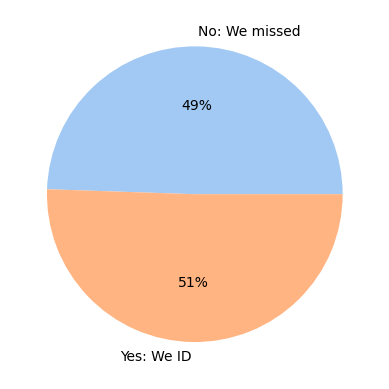

churn  Yes
row_0     
No     185
Yes    189


In [27]:
# Piechart showing counts of churners and churners who can be identified:

print(f'WHAT % OF CHURN CAN WE IDENTIFY?:')
plt.pie(data=graph_barry.iloc[:,1:2], x='Yes',
        labels=['No: We missed','Yes: We ID'],autopct='%.0f%%',
        colors = sns.color_palette('pastel')[0:5])
plt.show()
print(graph_barry.iloc[:,1:2])

# FINAL BOTTOM LINE:

### CUSTOMERS IN OUR LARGEST SEGMENT EXHIBIT THE HIGHEST CHURN RATES, AND WE NOW HAVE A WAY TO IDENTIFY A SIGNIFICANT PORTION OF THEM IN ORDER TO SEND TARGETED LOYALTY OFFERS. 

### We will continue to develop a refined ML Model which will allow us to identify Customer Churn before it occurs with ever-increasing accuracy.

## QUESTIONS, CONCERNS...fell free to call, email, visit!